In [1]:
%pdb

Automatic pdb calling has been turned ON


In [2]:
import math
from sortedcontainers import SortedDict
import random
import numpy 
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import truncnorm

In [3]:
# Code for generating positions, distances, travel times and preferences
def generate_positions(males, x_dim, y_dim):
    Xs = numpy.random.rand(males) * x_dim
    Ys = numpy.random.rand(males) * y_dim
    return [Xs,Ys]

def compute_distances_travel_times(males, positions, bird_speed):
    male_dist = numpy.zeros((males, males))
    travel_times = numpy.zeros((males, males))
    for i in range(males):
        for j in range(i + 1, males):
            dist = math.sqrt((positions[0][j] - positions[0][i]) ** 2 + (positions[1][j] - positions[1][i]) ** 2)
            travel = dist / bird_speed
            male_dist[j][i] = dist
            male_dist[i][j] = dist
            travel_times[j][i] = travel
            travel_times[i][j] = travel
    return (male_dist, travel_times)

def compute_visit_preferences(males, distances, lambda_dist):
    # compute exponential of each coefficient
    visit_preferences = numpy.exp(-lambda_dist * distances)
    # remove the identity matrix (exp(0) = 1)
    visit_preferences = visit_preferences - numpy.eye(males)
    # make rows sum to one
    visit_preferences = (visit_preferences.transpose() / numpy.sum(visit_preferences, 1)).transpose()
    return visit_preferences


In [4]:
# functions to generate tickets and manage timeline
def generate_ticket(start_time, end_time, length_activity, owner, action, target):
    global timeline
    ticket = {"start_time": start_time,
              "end_time": end_time,
              "length_activity": length_activity,
              "owner": owner,
              "action": action,
              "target": target
             }
    # now add to timeline
    timeline[(ticket["end_time"], ticket["owner"])] = ticket


In [5]:
# ACTION FUNCTIONS
# Each action generates a ticket, and updates the state of the owner (and possibly the target)

def draw_foraging_time(start_time):
    time_between = FG_tau_std * truncnorm.rvs(FG_tau_norm_range[0], FG_tau_norm_range[1]) + FG_tau_mean
    return start_time + time_between

def action_forage(bird_id, current_time):
    global birds
    # generate the time it takes to forage
    time_spent_foraging = numpy.random.gamma(FG_k, FG_theta)/FG_divisor
    time_action_ends = current_time + time_spent_foraging
    # generate the ticket
    generate_ticket(start_time = current_time,
                   end_time = time_action_ends,
                   length_activity = time_spent_foraging,
                   owner = bird_id,
                   action = "foraging",
                   target = -1)
    # update the bird:
    birds[bird_id]["current_state"] = "foraging"
    birds[bird_id]["action_starts"] = current_time
    birds[bird_id]["action_ends"] = time_action_ends
    birds[bird_id]["foraging_time_data"][0] += 1 # add one more foraging event
    birds[bird_id]["foraging_time_data"][1] += time_spent_foraging # add the time spent foraging
    birds[bird_id]["foraging_time_data"][2] += time_spent_foraging ** 2 #add the time spent foraging squared
    # update the time to next foraging: start counting when foraging ended
    birds[bird_id]["next_foraging_time"] = draw_foraging_time(time_action_ends)

def action_stay_at_bower(bird_id, current_time):
    global birds
    # generate the length of the stay
    time_spent_at_bower = RBSB_tau_std * truncnorm.rvs(RBSB_tau_norm_range[0], RBSB_tau_norm_range[1]) + RBSB_tau_mean
    time_action_ends = current_time + time_spent_at_bower
    # generate the ticket
    generate_ticket(start_time = current_time,
                   end_time = time_action_ends,
                   length_activity = time_spent_at_bower,
                   owner = bird_id,
                   action = "staying at bower",
                   target = -1)
    # update the bird:
    birds[bird_id]["current_state"] = "staying at bower"
    birds[bird_id]["action_starts"] = current_time
    birds[bird_id]["action_ends"] = time_action_ends
    birds[bird_id]["staying_time_data"][0] += 1 # add one more staying at bower event
    birds[bird_id]["staying_time_data"][1] += time_spent_at_bower # add the time spent at bower
    birds[bird_id]["staying_time_data"][2] += time_spent_at_bower ** 2 #add the time spent at bower squared

def action_travel_to_maraud(bird_id, current_time):
    global birds
    # choose who to maraud
    tmp = numpy.random.rand()
    target = numpy.argwhere(birds[bird_id]["travel_preferences"] > tmp)[0][0] 
    time_to_travel = birds[bird_id]["travel_times"][target]
    time_action_ends = current_time + time_to_travel
    # generate the ticket
    generate_ticket(start_time = current_time,
                   end_time = time_action_ends,
                   length_activity = time_to_travel,
                   owner = bird_id,
                   action = "travel to maraud",
                   target = target)
    # update the bird:
    birds[bird_id]["current_state"] = "travel to maraud"
    birds[bird_id]["action_starts"] = current_time
    birds[bird_id]["action_ends"] = time_action_ends
    birds[bird_id]["traveling_time_data"][0] += 1 # add one more travel event
    birds[bird_id]["traveling_time_data"][1] += time_to_travel * 2 # add the time spent traveling
    birds[bird_id]["traveling_time_data"][2] += (time_to_travel ** 2) * 2 #add the time spent traveling squared
    #NOTE: use * 2 to account for return time, as well
    
def action_repair_bower(bird_id, current_time):
    global birds
    # generate the length of the repair bout
    time_spent_repairing_bower = RBSB_tau_std * truncnorm.rvs(RBSB_tau_norm_range[0], RBSB_tau_norm_range[1]) + RBSB_tau_mean
    time_action_ends = current_time + time_spent_repairing_bower
    # generate the ticket
    generate_ticket(start_time = current_time,
                   end_time = time_action_ends,
                   length_activity = time_spent_repairing_bower,
                   owner = bird_id,
                   action = "repairing bower",
                   target = -1)
    # update the bird:
    birds[bird_id]["current_state"] = "repairing bower"
    birds[bird_id]["action_starts"] = current_time
    birds[bird_id]["action_ends"] = time_action_ends
    birds[bird_id]["repairing_time_data"][0] += 1 # add one more travel event
    birds[bird_id]["repairing_time_data"][1] += time_spent_repairing_bower # add the time spent traveling
    birds[bird_id]["repairing_time_data"][2] += time_spent_repairing_bower ** 2 #add the time spent traveling squared
    # note: already accounts for the improvements
    birds[bird_id]["bower_state"] = birds[bird_id]["bower_state"] + time_spent_repairing_bower
    # cannot make it better than 0
    if birds[bird_id]["bower_state"] > 0.0:
        birds[bird_id]["bower_state"] = 0.0

def action_maraud(marauder_id, marauder_target, current_time):
    global birds
    # note: HARD CODED PARAMS!
    time_spent_marauding = 0.1 
    # note: HARD CODED PARAMS!
    damage_to_bower = 6.0 
    time_action_ends = current_time + time_spent_marauding
    # generate the ticket
    generate_ticket(start_time = current_time,
                   end_time = time_action_ends,
                   length_activity = time_spent_marauding,
                   owner = marauder_id,
                   action = "marauding",
                   target = marauder_target)
    # update marauder
    birds[marauder_id]["current_state"] = "marauding"
    birds[marauder_id]["action_starts"] = current_time
    birds[marauder_id]["action_ends"] = time_action_ends
    birds[marauder_id]["marauding_time_data"][0] += 1 # add one more travel event
    birds[marauder_id]["marauding_time_data"][1] += time_spent_marauding # add the time spent traveling
    birds[marauder_id]["marauding_time_data"][2] += time_spent_marauding ** 2 #add the time spent traveling squared
    # update target
    birds[marauder_target]["bower_state"] = birds[marauder_target]["bower_state"] - damage_to_bower
    

def action_travel_from_maraud(marauder_id, marauder_target, current_time):
    global birds
    time_from_travel = birds[marauder_id]["travel_times"][marauder_target]
    time_action_ends = current_time + time_from_travel
    # generate the ticket
    generate_ticket(start_time = current_time,
                   end_time = time_action_ends,
                   length_activity = time_from_travel,
                   owner = marauder_id,
                   action = "travel from maraud",
                   target = marauder_target)
    # update the bird:
    birds[marauder_id]["current_state"] = "travel from maraud"
    birds[marauder_id]["action_starts"] = current_time
    birds[marauder_id]["action_ends"] = time_action_ends


    
def action_mating_attempt(female_id, current_time):
    global birds
    global female_birds
    female_index = int(female_id[1:]) #convert from ID to index; i.e. "F0" -> 0
    female = female_birds[female_index] # extract female
    last_location = female["already_visited"][-1] #index of most recently visited male
    p = birds[last_location]["travel_preferences"].copy()
    # this line "undoes" the cumulative sum
    p = numpy.diff(numpy.concatenate((numpy.array([0]), p)))
    extra_wait = 0.0
    if len(female["already_visited"]) == female["max_per_day"]:
        female["already_visited"] = []
        extra_wait = female["wait_period"]  
    tmp = numpy.random.rand()
    p = numpy.cumsum(p)
    scale_rand = p[-1]
    tmp = numpy.random.rand() * scale_rand
    target = numpy.argwhere(p > tmp)[0][0]
    time_to_travel = birds[last_location]["travel_times"][target]
    time_action_ends = current_time + time_to_travel
    generate_ticket(start_time = time_action_ends + extra_wait, #HARD CODE
                    end_time = time_action_ends + extra_wait,
                    length_activity = time_to_travel + extra_wait,
                    owner = female_id,
                    action = "mating attempt",
                    target = target)
        

In [6]:
# this function should be called every time the bird 
# 1) is back to the bower (from foraging, marauding), 
# 2) has finished repairing the bower, 
# 3) or has finished a stint at staying at bower
def choose_action(bird, current_time):
    global t_max
    # stop generating actions at t_max
    if current_time < t_max:
        # if it's time to eat
        if current_time > bird["next_foraging_time"]:
            action_forage(bird["id"], current_time)
        # if the bower needs repair
        elif bird["bower_state"] < 0.0:
            # go repair
            action_repair_bower(bird["id"], current_time)
        # check if it wants to maraud
        elif numpy.random.rand() < bird["probability_maraud"]:
            # go maraud
            action_travel_to_maraud(bird["id"], current_time)
        else:
            # stay at bower
            action_stay_at_bower(bird["id"], current_time)
       

In [7]:
def initialize_male(bird_id, bird_strategy, bird_xy, bird_preferences, bird_travel_times):
    # initialize dictionary
    bird = {"id": bird_id,
            "current_state": "none",
            "action_starts": 0.0,
            "action_ends": -1.0,
            "probability_maraud": bird_strategy,
            "bower_state": 0.0,
            "successful_mating": 0,
            "next_foraging_time": draw_foraging_time(0.0),
            "travel_preferences": numpy.cumsum(bird_preferences), # note: store cumulative probability for faster choice
            "travel_times": bird_travel_times, 
            "position": bird_xy,
            "foraging_time_data": [0.0, 0.0, 0.0], #number of events, cumulative time spent, sum(duration^2)
            "staying_time_data": [0.0, 0.0, 0.0],
            "repairing_time_data": [0.0, 0.0, 0.0],
            "marauding_time_data": [0.0, 0.0, 0.0],
            "traveling_time_data": [0.0, 0.0, 0.0]
            }
    return(bird)


In [8]:
def initialize_female(female_id, males):
    #initialize dictionary
    female_bird = {"id": female_id,
             "already_visited": [numpy.random.randint(males)], # choose a random male to be the "last visited"
             "max_per_day": min(males - 1, 6),
             "wait_period": 12,
            #HARD CODED PARAMS
            }
    return(female_bird)

In [9]:
# this is the most important function!
def read_ticket(tic):
    global birds
    global t_max
    if tic["action"] in ("foraging", "staying at bower", "repairing bower", "travel from maraud"):
        # I am back at the bower, choose new action
        choose_action(birds[tic["owner"]], tic["end_time"])
    elif tic["action"] == "travel to maraud":
        # check whether the target is at home
        go_maraud = True
        if birds[tic["target"]]["current_state"] in ("staying at bower", "repairing bower"):
            go_maraud = False
        if birds[tic["target"]]["bower_state"] < 0.0:
            go_maraud = False
        if go_maraud: # maraud
            action_maraud(tic["owner"], tic["target"], tic["end_time"])
        else: # go back
            action_travel_from_maraud(tic["owner"], tic["target"], tic["end_time"])
    elif tic["action"] == "marauding":
        # travel back
        action_travel_from_maraud(tic["owner"], tic["target"], tic["end_time"])
    elif tic["action"] == "mating attempt":
        if birds[tic["target"]]["current_state"] == "staying at bower": #if male is at bower and it is intact
            birds[tic["target"]]["successful_mating"] += 1 #successfully mate and stop generating tickets
        else:  
            female_birds[int(tic["owner"][1:])]["already_visited"].append(tic["target"]) #update the female's already_visited list
            if tic['end_time'] < t_max:
                action_mating_attempt(tic["owner"], tic["end_time"]) #generate a new ticket
    else:
        1 / 0 # something went horribly wrong
    

In [10]:
# Global Variables

# TIMELINE
timeline = SortedDict()
t_max = 12*10 #12 * 30 # time when simulation ends

# MALES
males = 100 # number of male birds

# FEMALES
F_per_M = 5 #The number of sexualy mature females per sexually mature male
females = males * F_per_M # number of female birds
female_visit_param = [0, t_max / 2.0] # females visit early in the period

# POSITIONS AND TRAVEL TIME
x_dim, y_dim = 400, 500 # dimensions of environment
bird_speed = 12 * 3600 # m/hr (12 m/s)
# now choose lambda_dist, controlling the probability of traveling to a neighbor
# the probability of choosing a neighbor at distance x is proportional to exp(-\lambda x)
# choose lambda such that 99% of the mass is before 800 meters
improb = 0.99
improb_distance = 800
lambda_dist = - math.log(1.0 - improb) / improb_distance

# ACTION DISTRIBUTIONS
# Time of forage
FG_tau_mean, FG_tau_std = .4, .167 #mean and sd of truncated normal distribution rv to find a male's time until next FG
FG_tau_range = [0, 1] #maximum and minimum FG taus
FG_tau_norm_range = [(FG_tau_range[0] - FG_tau_mean) / FG_tau_std, (FG_tau_range[1] - FG_tau_mean) / FG_tau_std] #normalized
# Duration of forage
FG_k=1.5 #the shape of the gamma distribution rv used to generate FG taus
FG_theta=5 #the scale of the gamma distribution rv used to generate FG taus
FG_divisor=60
# Duration of repair bower / stay at bower
RBSB_tau_mean, RBSB_tau_std = .1583, .09755 #mean and sd of truncated normal distribution rv to find duration of repair bower / stay at bower
RBSB_tau_range = [0,.5] #maximum and minimum taus
RBSB_tau_norm_range = [(RBSB_tau_range[0] - RBSB_tau_mean) / RBSB_tau_std, (RBSB_tau_range[1] - RBSB_tau_mean) / RBSB_tau_std] #normalized



# BIRDS
birds = []
female_birds=[]

strategies = numpy.random.random(males)

# DEBUG
past_events = []
timeline_lengths = []

######## CODE SIMULATION #########
numpy.random.seed(0)

# initialize positions, travel times and preferences
positions = generate_positions(males, x_dim, y_dim)
distances, travel_times = compute_distances_travel_times(males, positions, bird_speed)
visit_preferences = compute_visit_preferences(males, distances, lambda_dist)
for i in range(males):
    birds.append(initialize_male(i, 
                                 strategies[i], 
                                 (positions[0][i], positions[1][i]), 
                                 visit_preferences[i],
                                 travel_times[i]))
    # choose its first action
    choose_action(birds[-1], 0.0)

#initialize females
for i in range(females): #females
    female_id = "F" + str(i)
    female_birds.append(initialize_female(female_id, males)) #female IDs start where males end (if there are 10 males, the first female would be 11)
    #choose time for initial mating attempt
    first_time = numpy.random.uniform(female_visit_param[0], female_visit_param[1])
    action_mating_attempt(female_id, first_time)
    
# this is the main loop
while len(timeline) > 0:
    current_ticket = timeline.popitem(0)
    read_ticket(current_ticket[1])
    # for debug: store all the past tickets
    past_events.append(current_ticket)
    # and every so often check the length of the timeline
    if numpy.random.rand() < 0.01:
        timeline_lengths.append(len(timeline))


In [11]:
strategy_fitness = [[],[]]
for i in range(males):
    strategy_fitness[0].append(birds[i]["probability_maraud"])
    strategy_fitness[1].append(birds[i]["successful_mating"])
    #print("bird: {:d}; matings: {:d}; strategy: {:f}".format(i, birds[i]["successful_mating"], birds[i]["probability_maraud"]))


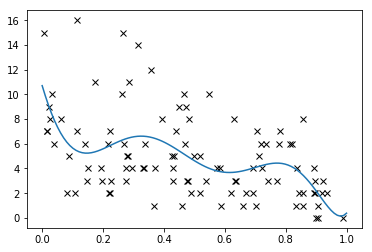

In [12]:
x = strategy_fitness[0]
y = strategy_fitness[1]
plt.plot(x, y, 'kx')

coeffs_poly = numpy.polyfit(x,y,7) #fit a polynomial (degree 7) to the data
x2 = numpy.linspace(0, 1, 100)
y2 = numpy.polyval(coeffs_poly, x2)

plt.plot(x2, y2)

In [13]:
for i in range(5): #can print more if you want
    global t_max
    print("bird " + str(i) + ": ")
    print("strategy: " + str(birds[i]["probability_maraud"]))
    print("")
    print("% time foraging: " + str(100 * birds[i]["foraging_time_data"][1] / t_max))
    print("% time at bower: " + str(100 * birds[i]["staying_time_data"][1] / t_max))
    print("% time repairing: " + str(100 * birds[i]["repairing_time_data"][1] / t_max))
    print("% time traveling to maraud: " + str(100 * birds[i]["traveling_time_data"][1] / t_max))
    print("% time marauding: " + str(100 * birds[i]["marauding_time_data"][1] / t_max))
    t = 100 * (birds[i]["foraging_time_data"][1] + birds[i]["staying_time_data"][1] + birds[i]["repairing_time_data"][1] + birds[i]["traveling_time_data"][1] + birds[i]["marauding_time_data"][1])/t_max
    print(t) #this is just a check to see that we are very close to adding up to 100%... it goes a little over, but that's fine
    print("")
    print("foraging events: " + str(birds[i]["foraging_time_data"][0]))
    print("bower-staying events: " + str(birds[i]["staying_time_data"][0]))
    print("bower-repairing events: " + str(birds[i]["repairing_time_data"][0]))
    print("all marauding attempts: " + str(birds[i]["traveling_time_data"][0]))
    print("successful marauding events only: " + str(birds[i]["marauding_time_data"][0]))
    print("")
    print("################################################################")
    print("")


bird 0: 
strategy: 0.06172703596405993

% time foraging: 19.758969860108753
% time at bower: 26.871485918819495
% time repairing: 53.468010735402196
% time traveling to maraud: 0.05626013271264066
% time marauding: 0.0
100.15472664704309

foraging events: 181.0
bower-staying events: 196.0
bower-repairing events: 365.0
all marauding attempts: 11.0
successful marauding events only: 0.0

################################################################

bird 1: 
strategy: 0.1071928291678701

% time foraging: 20.45438422685602
% time at bower: 24.08612174224329
% time repairing: 55.33242069359355
% time traveling to maraud: 0.10817099753537948
% time marauding: 0.08333333333333333
100.06443099356156

foraging events: 182.0
bower-staying events: 172.0
bower-repairing events: 392.0
all marauding attempts: 15.0
successful marauding events only: 1.0

################################################################

bird 2: 
strategy: 0.33164015211830467

% time foraging: 19.181699889949464
% ti

In [14]:
debug = False

In [15]:
if debug:
    # DEBUG: MAKE SURE THAT TIMELINE MAKES SENSE
    for my_bird in range(males):
        print("#################################")
        print("TIMELINE OF BIRD", my_bird)
        print("#################################")
        bird_actions = {}
        for event in past_events:
            tic = event[1]
            if tic["owner"] == my_bird:
                print(round(tic["start_time"], 3), "-", round(tic["end_time"], 3),
                     "->", tic["action"], "[target:", tic["target"], "]")
        print("#################################")
        print("")
        print("")    

In [16]:
if debug:
    # DEBUG: check that timeline does not bloat!
    print(timeline_lengths)

In [17]:
if debug:
    # DEBUG: MAKE SURE THAT FEMALE TIMELINE MAKES SENSE
    for i in range(females):
        my_bird = "F{:d}".format(i)
        print("#################################")
        print("TIMELINE OF BIRD", my_bird)
        print("#################################")
        bird_actions = {}
        for event in past_events:
            tic = event[1]
            if tic["owner"] == my_bird:
                print(round(tic["start_time"], 3), "-", round(tic["end_time"], 3),
                     "->", tic["action"], "[target:", tic["target"], "]")
        print("#################################")
        print("")
        print("") 